In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import time
import numpy as np
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from statistics import mean
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
import pickle

/home/bogdan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Processing Data

In [12]:
df = pd.read_csv ('ProcessedDataset.csv', sep=',')
df.columns = df.columns.str.strip()
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)


#print(df.head())
label_encoder = LabelEncoder()
df['proto'] = label_encoder.fit_transform(df['proto'])
df['sp'] = label_encoder.fit_transform(df['sp'])
df['tag'] = label_encoder.fit_transform(df['tag'])
df['rtag'] = label_encoder.fit_transform(df['rtag'])
#print(df.head())


malicious_count = df['malicious'].value_counts()[True]
non_malicious_count = df['malicious'].value_counts()[False]
print(non_malicious_count)
print (malicious_count )
print(non_malicious_count / (malicious_count + non_malicious_count ))

#malicious_fraction = 100 * (non_malicious_count - malicious_count) / non_malicious_count
#perform undersampling as we go from 0.4% to 4%

df = df.drop(df[df['malicious'] == True].sample(frac=0.9).index)
malicious_count = df['malicious'].value_counts()[True]
non_malicious_count = df['malicious'].value_counts()[False]
print(non_malicious_count)
print (malicious_count )
print(non_malicious_count / (malicious_count + non_malicious_count ))


malicious_count = df['malicious'].value_counts()[True]
non_malicious_count = df['malicious'].value_counts()[False]
smote = SMOTE(random_state=42)

X = df.drop(columns=['malicious',])
y = df['malicious']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Apply SMOTE to the training data only
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_smote).value_counts())

272
65541
0.0041329220670688165
272
6554
0.039847641371227656
Class distribution before SMOTE: malicious
True     4598
False     180
Name: count, dtype: int64
Class distribution after SMOTE: malicious
True     4598
False    4598
Name: count, dtype: int64


## Training Multiple Models

### Training a Random Forest Model

In [13]:
srf = RandomForestClassifier(n_estimators=300, random_state=42,bootstrap= False, min_samples_split= 10,min_samples_leaf=2,max_depth= 20)
srf.fit(X_smote, y_smote)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=300, random_state=42)

### Training a Balanced Random Forest Model

In [4]:
brf = BalancedRandomForestClassifier(n_estimators=300, random_state=42,bootstrap= False, min_samples_split= 10,min_samples_leaf=2,max_depth= 20,sampling_strategy='all',replacement=True)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, max_depth=20,
                               min_samples_leaf=2, min_samples_split=10,
                               n_estimators=300, random_state=42,
                               replacement=True, sampling_strategy='all')

### Training a Logistical Regression Model

In [17]:
logisticalRegression = LogisticRegression(max_iter=10000)
logisticalRegression.fit(X_smote, y_smote)

LogisticRegression(max_iter=10000)

### Evaluating Each Model

### Random Forests

1.0


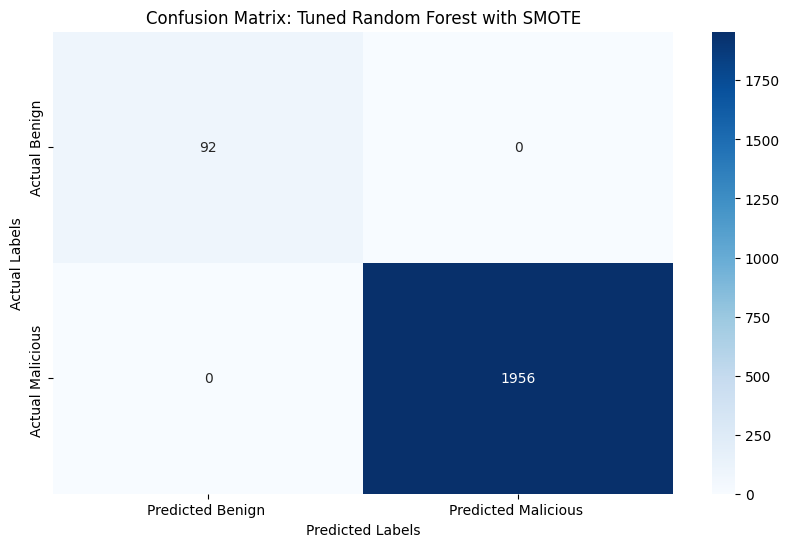

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        92
        True       1.00      1.00      1.00      1956

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



(92, 0, 0, 1956)

In [24]:
y_pred_test_srf = srf.predict(X_test)
print(accuracy_score(y_test, y_pred_test_srf ))
cm=confusion_matrix(y_test, y_pred_test_srf)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Benign ', 'Predicted Malicious '],
            yticklabels=['Actual Benign', 'Actual Malicious '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Tuned Random Forest with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_srf))
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

### Balanced Random Forests

0.9962013776337115


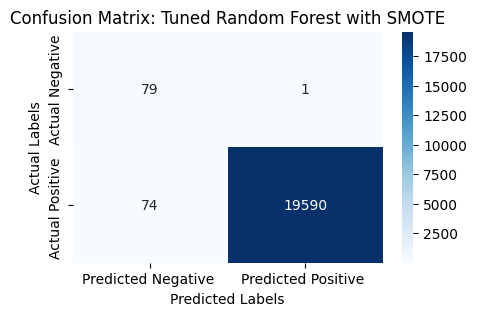

              precision    recall  f1-score   support

       False       0.52      0.99      0.68        80
        True       1.00      1.00      1.00     19664

    accuracy                           1.00     19744
   macro avg       0.76      0.99      0.84     19744
weighted avg       1.00      1.00      1.00     19744



In [5]:
y_pred_test_brf = brf.predict(X_test)
print(accuracy_score(y_test, y_pred_test_brf ))
cm=confusion_matrix(y_test, y_pred_test_brf)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative ', 'Predicted Positive '],
            yticklabels=['Actual Negative', 'Actual Positive '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Tuned Random Forest with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_brf))

### Logistical Regression

0.9404296875


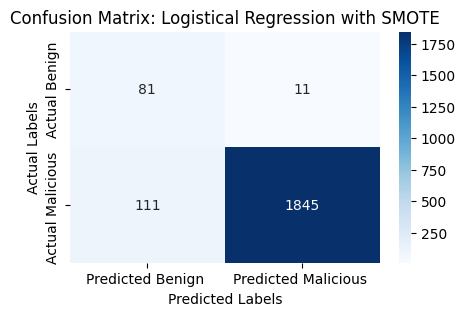

              precision    recall  f1-score   support

       False       0.42      0.88      0.57        92
        True       0.99      0.94      0.97      1956

    accuracy                           0.94      2048
   macro avg       0.71      0.91      0.77      2048
weighted avg       0.97      0.94      0.95      2048



In [25]:
y_pred_test_lrm = logisticalRegression.predict(X_test)
print(accuracy_score(y_test, y_pred_test_lrm ))
cm=confusion_matrix(y_test, y_pred_test_lrm)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Benign ', 'Predicted Malicious '],
            yticklabels=['Actual Benign', 'Actual Malicious '])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix: Logistical Regression with SMOTE')
plt.show()
print(classification_report(y_test, y_pred_test_lrm))

## Checking the importance of each feature for the forests model

### Random Forests

Elapsed time to compute the importances: 0.026 seconds


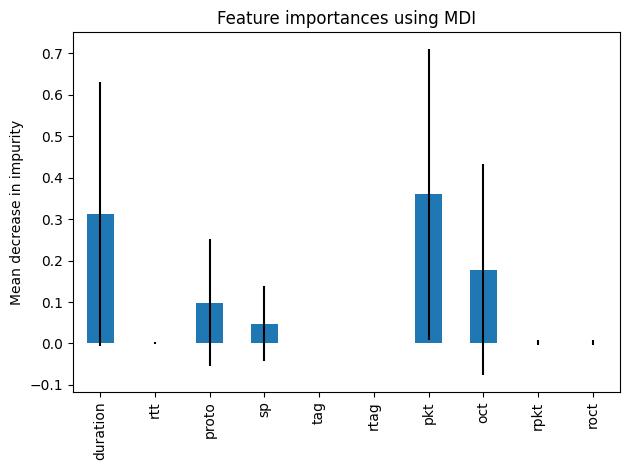

In [33]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns

start_time = time.time()
importances = srf.feature_importances_
std = np.std([tree.feature_importances_ for tree in srf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Balanced Random Forests

Elapsed time to compute the importances: 0.029 seconds


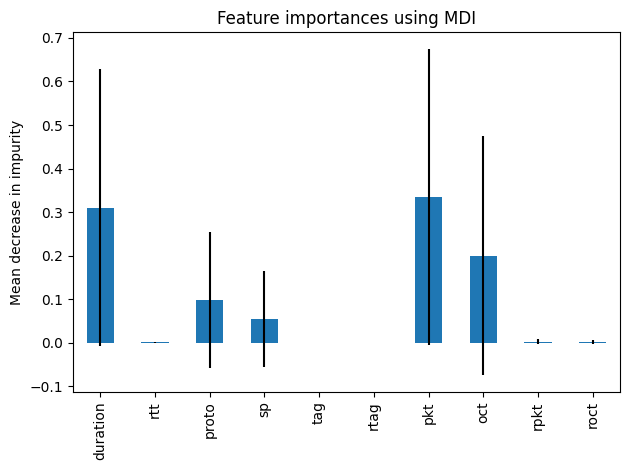

In [34]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns

start_time = time.time()
importances = brf.feature_importances_
std = np.std([tree.feature_importances_ for tree in brf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

rf_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [35]:
with open('trained_model.pkl', 'wb') as model_file:
    pickle.dump(srf, model_file)

# Saving the label encoder to a file
with open('label_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)